# Submitted by: Jonish Bishwakarma
# Week 7 & 8 Assignment

## Overview of Assignment
This assignment focuses on building a convolutional neural network (CNN) model using the Fruits 360 dataset to classify various fruit images. The objective is to implement an accurate image classification model while following best practices such as data augmentation, dropout layers, and model evaluation.

## Description of Data



1.   Dataset: [Fruits 360 dataset from Kaggle](https://www.kaggle.com/datasets/moltean/fruits)
2.   The dataset has four major branches:

*   The 100x100 branch
*   The original-size branch
*   The meta branch
*   The multi branch

3. We will work on the original-size branch
* Total number of images: 20676.
* Training set size: 10342 images.

* Validation set size: 5177 images

* Test set size: 5157 images.

* Number of classes: 37 (fruits, vegetables and nuts).

















In [8]:
# Upload our kaggle.json file
from google.colab import files
files.upload()  # Manually upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonishb","key":"cc7d160d2a3a4c4a672a3160aeb66f9f"}'}

In [9]:
# Move it to ~/.kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Download Fruits 360 dataset
!kaggle datasets download -d moltean/fruits
!unzip fruits.zip -d fruits_dataset

Streaming output truncated to the last 5000 lines.
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_165.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_169.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_17.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_173.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_177.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_181.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_185.jpg  
  inflating: fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Validation/Apple 12/r0_189.jpg 

In [5]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [43]:
!ls /content/fruits_dataset/


fruits-360_dataset_100x100  fruits-360_dataset_multi
fruits-360_dataset_meta     fruits-360_dataset_original-size


It looks like the dataset was extracted into 2 different folders with different file sizes. We will go with original-size dataset for more accuracy.

In [3]:
train_path = "/content/fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Training"
test_path = "/content/fruits_dataset/fruits-360_dataset_original-size/fruits-360-original-size/Test"


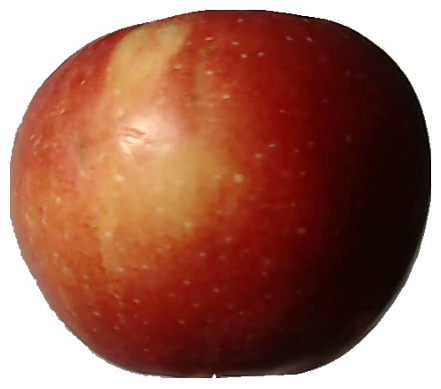

In [11]:
# Display sample image
img_path = train_path + "/apple_braeburn_1/r0_0.jpg"
img = load_img(img_path)
plt.imshow(img)
plt.axis("off")
plt.show()

## Data Preparation:
Data Augmentation was applied to the training set with parameters like rotation, zoom, shear, and flipping to enhance model generalization. Image data was rescaled by 1/255 for better convergence.

In [16]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [17]:
# Rescale test data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)


In [18]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 8404 images belonging to 38 classes.
Found 2088 images belonging to 38 classes.


In [19]:
# Load test data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(100, 100),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5232 images belonging to 38 classes.


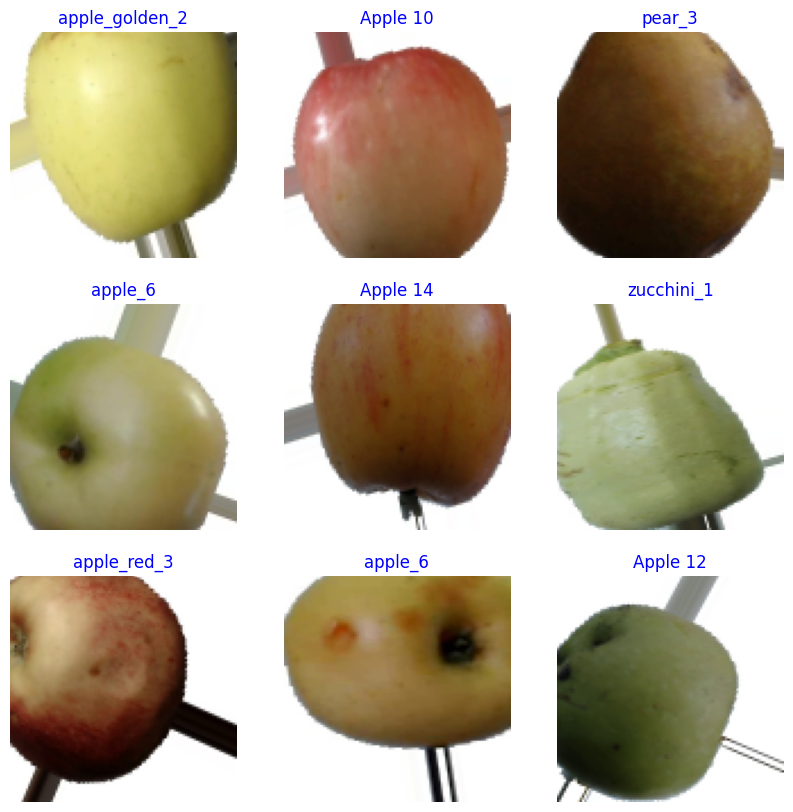

In [20]:
# Get class indices mapping
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())  # Convert to list for indexing

# Display sample images with labels
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    label_index = np.argmax(sample_labels[i])  # Get index of max value in one-hot encoding
    plt.title(class_names[label_index], fontsize=12, color='blue')  # Display class label
    plt.axis("off")
plt.show()

## Convolutional Neural Networks (CNNs / ConvNets)
A convolutional neural network (CNN or ConvNet) is a network architecture for deep learning that learns directly from data. CNNs are particularly useful for finding patterns in images to recognize objects, classes, and categories. They can also be quite effective for classifying audio, time-series, and signal data.

CNNs provide an optimal architecture for uncovering and learning key features in image and time-series data.

## How CNNs Work ?
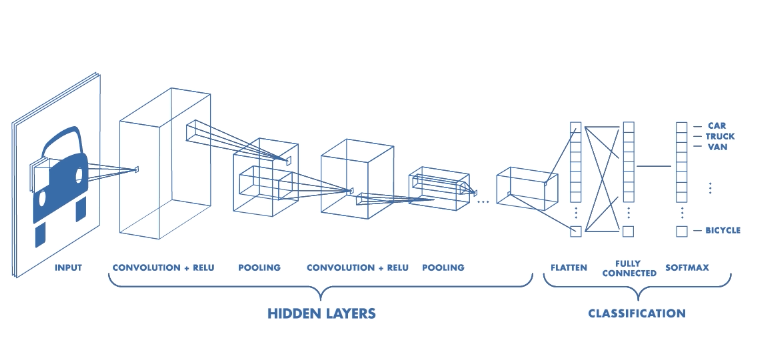

## Model Architecture:
A Sequential CNN model with:
3 convolutional layers (with 32, 64, and 128 filters). Each convolution layer is followed by BatchNormalization and MaxPooling2D layers for improved learning and reduced overfitting. Dropout layers (0.2 to 0.5) were used to reduce overfitting. The model concludes with a Dense Layer for classification using the softmax activation function.

In [21]:
# Define CNN model with BatchNormalization, Dropout, and Convolution layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Model Compilation:
Categorical cross-entropy loss function since this is a multi-class classification problem.

In [33]:
# Compile the model
model.compile(
    optimizer = "rmsprop",
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


While we are fitting the model we have to arrange some hyperparameter.These are epochs,steps_per_epoch and validation_steps.

In [35]:
# Train the model
history = model.fit(
     train_generator,
        steps_per_epoch=1600 // 32,
        epochs=100,
        validation_data=test_generator,
        validation_steps=800 // 32)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.9068 - loss: 0.2791 - val_accuracy: 0.9937 - val_loss: 0.0238
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9011 - loss: 0.2739 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.9195 - loss: 0.2798 - val_accuracy: 1.0000 - val_loss: 9.9636e-04
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.9256 - loss: 0.2177 - val_accuracy: 1.0000 - val_loss: 1.6037e-05
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9211 - loss: 0.2439 - val_accuracy: 1.0000 - val_loss: 4.0681e-06
Epoch 6/100
12/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9500 - loss: 0.1921

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9442 - loss: 0.1790 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.9207 - loss: 0.2437 - val_accuracy: 1.0000 - val_loss: 1.8365e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.9211 - loss: 0.2977 - val_accuracy: 0.9975 - val_loss: 0.0066
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9288 - loss: 0.2161 - val_accuracy: 0.9725 - val_loss: 0.1864
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9368 - loss: 0.2040 - val_accuracy: 0.9375 - val_loss: 0.2740
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9344 - loss: 0.2067 - val_accuracy: 1.0000 - val_loss: 5.9542e-04
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9310 - loss: 0.2544 - val_accuracy: 0.9350 - val_loss: 0.2922
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9220 - loss: 0.2284 - val_accura

In [36]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")


164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9787 - loss: 0.1123
Test Accuracy: 0.96


We achieved accuracy of 96 % .

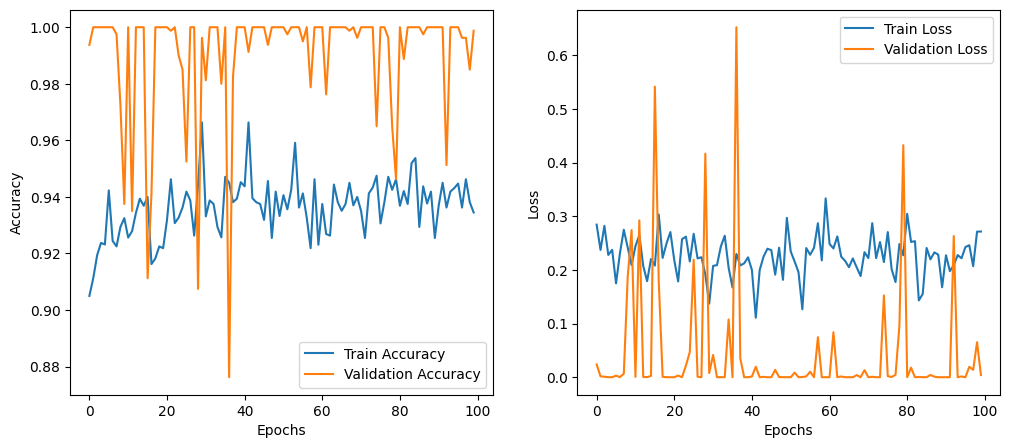

In [42]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The accuracy plot shows training accuracy stabilizing around 93-94% while validation accuracy frequently reaches 100% but with sharp drops, suggesting some instability. The loss plot confirms this pattern with validation loss often near zero but experiencing occasional spikes up to 0.6, indicating the model might be overfitting to the validation set despite dropout layers.

164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step


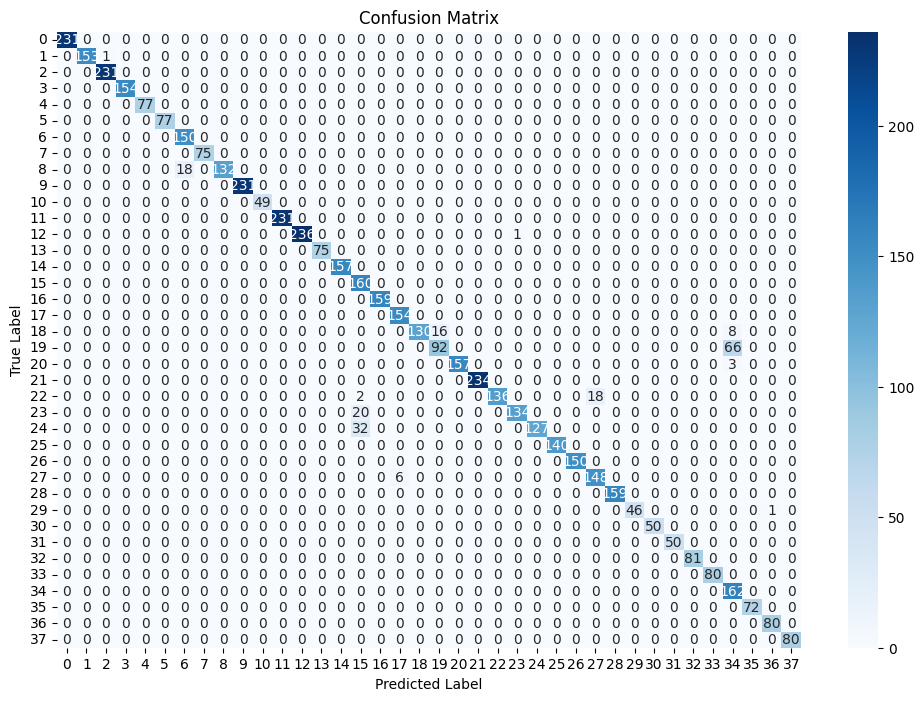

In [38]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix reveals excellent classification performance with most predictions concentrated along the diagonal (correct classifications). The few off-diagonal elements indicate minimal confusion between classes. This strong diagonal pattern visually confirms the high 96% test accuracy achieved by the model.

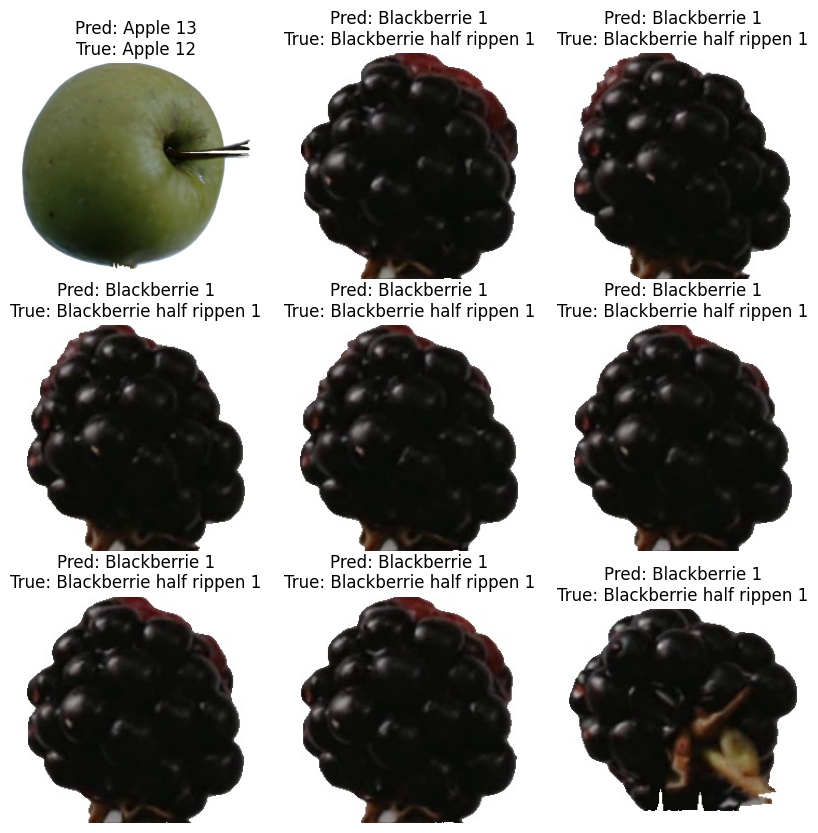

In [39]:
# Display incorrect predictions
incorrect = np.where(y_pred != y_true)[0]
plt.figure(figsize=(10, 10))
for i, idx in enumerate(incorrect[:9]):
    plt.subplot(3, 3, i+1)
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Pred: {list(test_generator.class_indices.keys())[y_pred[idx]]}\nTrue: {list(test_generator.class_indices.keys())[y_true[idx]]}")
    plt.axis("off")
plt.show()

The misclassification examples show confusion between similar fruit varieties. Most images display blackberries being correctly identified, with only one significant error where an apple variety (Apple 13) was predicted for a different apple variety (Apple 12). This suggests the model struggles most with distinguishing between subvarieties of the same fruit rather than between entirely different fruits.

# Summary

We built a Convolutional Neural Network (CNN) to classify images from the Fruits 360 dataset. We worked specifically with the original-size branch, which contained 20,676 images across 37 classes of fruits, vegetables, and nuts. After loading the dataset, we applied data augmentation techniques including rotation, zoom, shear, and horizontal flipping to improve model generalization. Our CNN architecture consisted of three convolutional layers (32, 64, and 128 filters) with batch normalization, max pooling, and increasing dropout rates (0.2 to 0.5) to prevent overfitting.

The model was compiled using categorical cross-entropy loss and trained for 100 epochs. Performance evaluation showed excellent results with a test accuracy of 96%. We visualized the model's performance through accuracy/loss curves, confusion matrices, and examples of incorrect predictions to better understand the model's strengths and limitations.